In [1]:
import pandas as pd
import numpy as np
import random
import warnings
from utils import *
from datasets import *
from models import *

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set display options
pd.set_option("display.max_rows", 500)  # Replace 500 with your desired number of rows
pd.set_option(
    "display.max_columns", 10
)  # Replace 10 with your desired number of columns
pd.set_option("display.width", 1000)  # Adjust the width as needed
pd.set_option("display.max_colwidth", 50)  # Adjust the column width as needed

### Data Preparation

In [2]:
# Prepare the data
# Adjust your path here
quality_df_dir = './results/quality_scores_per_subject.csv'
features_dir = "dataset_sample/features_df/"
info_dir = "dataset_sample/participant_info.csv"
clean_df, new_features, good_quality_sids = data_preparation(
    threshold = 0.2, 
    quality_df_dir = quality_df_dir,
    features_dir = features_dir,
    info_dir = info_dir)
print(clean_df.shape)
print(len(new_features))

(82671, 610)
597


### Split data to train, val, and test

In [3]:
SW_df, final_features = split_data(clean_df, good_quality_sids, new_features)
SW_df

,PPG_Rate_Mean,HRV_SDNN,HRV_MadNN,HRV_SDRMSSD,HRV_Prc20NN,...,Hypopnea,Multiple_Events,artifact,sid,BMI
1,87.451445,267.856258,277.987500,0.762788,468.750,...,0.0,0.0,0,S003,51.0
2,84.687304,280.299933,231.656250,0.672688,515.625,...,0.0,0.0,1,S003,51.0
3,90.889185,224.392912,208.490625,0.730625,465.625,...,0.0,0.0,1,S003,51.0
4,79.140186,303.274460,324.318750,0.769270,468.750,...,0.0,0.0,1,S003,51.0
5,90.383327,297.089740,289.570312,0.767894,450.000,...,0.0,0.0,1,S003,51.0
...,...,...,...,...,...,...,...,...,...,...,...
85066,61.392727,132.432765,23.165625,0.856175,1000.000,...,0.0,0.0,0,S102,26.0
85067,61.198295,138.500822,46.331250,1.081764,978.125,...,0.0,0.0,0,S102,26.0
85068,57.181574,18.233936,23.165625,0.781327,1031.250,...,0.0,0.0,0,S102,26.0
85069,57.535505,17.652470,23.165625,0.934502,1031.250,...,0.0,0.0,0,S102,26.0


In [4]:
import random
random.seed(0)
train_sids = random.sample(good_quality_sids, 56)
remaining_sids = [subj for subj in good_quality_sids if subj not in train_sids]
val_sids = random.sample(remaining_sids, 8)
test_sids = [subj for subj in remaining_sids if subj not in val_sids]

group_variables = ['AHI_Severity', 'Obesity']
# when idx == 0, it returns ['AHI_Severity'], the first variable in the list
# when idx == 1, it returns ['Obesity'], the second variable in the list
group_variable = get_variable(group_variables, idx = 0) # set your variable

In [5]:
X_train, y_train, group_train = train_test_split(SW_df, train_sids, final_features, group_variable)
print("Train data balance: ")
print(np.unique(y_train, return_counts=True))
print('')

X_val, y_val, group_val = train_test_split(SW_df, val_sids, final_features, group_variable)
print("Validation data balancpredicted_probabilitiese: ")
print(np.unique(y_val, return_counts=True))
print('')

X_test, y_test, group_test = train_test_split(SW_df, test_sids, final_features, group_variable)
print("Test data balance: ")
print(np.unique(y_test, return_counts=True))
print(y_train.sum())

Train data balance: 
(array([0., 1.]), array([33063, 24620]))

Validation data balancpredicted_probabilitiese: 
(array([0., 1.]), array([5001, 3038]))

Test data balance: 
(array([0., 1.]), array([10402,  6547]))
24620.0


### Resample data

In [6]:
X_train_resampled, y_train_resampled, group_train_resampled = resample_data(X_train, y_train, group_train, group_variable)

### LightGBM

In [7]:
final_lgb_model = LightGBM_engine(X_train_resampled, y_train_resampled, X_val, y_val)

100%|██████████| 50/50 [03:04<00:00,  3.70s/trial, best loss: -0.7038043478260869]
Best hyperparameters: {'learning_rate': 0.2659894878962815, 'max_depth': 3.0, 'n_estimators': 260.0, 'num_leaves': 90.0, 'reg_alpha': 10.0, 'reg_lambda': 0.2024957621336576}


/home/admin/miniconda3/envs/dreamt/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33063, number of negative: 33063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91238
[LightGBM] [Info] Number of data points in the train set: 66126, number of used features: 358
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[[29831  3232]
 [ 3704 20916]]


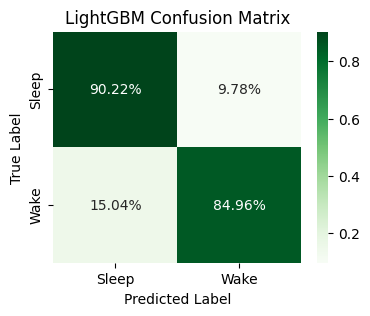

[[8806 1596]
 [ 822 5725]]


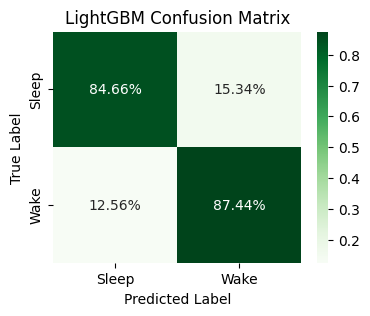

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,LightGBM,0.781997,0.874446,0.825642,0.846568,0.93492,0.917605,0.857337,0.696148


In [8]:
# calculate training scores
prob_ls_train, len_train, true_ls_train = compute_probabilities(
    train_sids, SW_df, final_features, "lgb", final_lgb_model, group_variable)
lgb_train_results_df = LightGBM_result(final_lgb_model, X_train, y_train, prob_ls_train, true_ls_train)

# # calculate testing scores
prob_ls_test, len_test, true_ls_test = compute_probabilities(
    test_sids, SW_df, final_features, "lgb", final_lgb_model, group_variable)
lgb_test_results_df = LightGBM_result(final_lgb_model, X_test, y_test, prob_ls_test, true_ls_test)
lgb_test_results_df


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


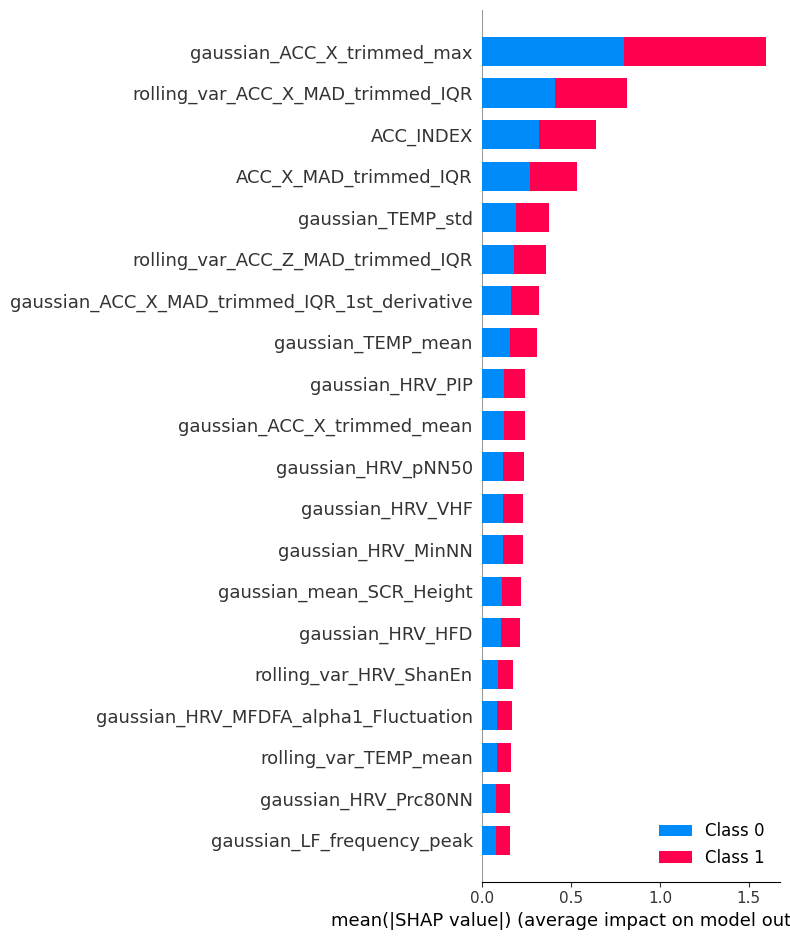

In [9]:
import shap
explainer = shap.TreeExplainer(final_lgb_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=final_features)

### LightGBM and LSTM post processing

In [10]:
dataloader_train = LSTM_dataloader(
    prob_ls_train, len_train, true_ls_train, batch_size=32
)

# Run LSTM model
LSTM_model = LSTM_engine(dataloader_train, num_epoch=300, hidden_layer_size=32, learning_rate=0.001) # set your num_epoch

Training on cpu


dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1


Epoch 5/300 - Loss: 0.6531, Accuracy: 0.6254
Epoch 10/300 - Loss: 0.6131, Accuracy: 0.6254
Epoch 15/300 - Loss: 0.5320, Accuracy: 0.8666
Epoch 20/300 - Loss: 0.3630, Accuracy: 0.9056
Epoch 25/300 - Loss: 0.3312, Accuracy: 0.8987
Epoch 30/300 - Loss: 0.3037, Accuracy: 0.9093
Epoch 35/300 - Loss: 0.2963, Accuracy: 0.9094
Epoch 40/300 - Loss: 0.2912, Accuracy: 0.9094
Epoch 45/300 - Loss: 0.2869, Accuracy: 0.9096
Epoch 50/300 - Loss: 0.2838, Accuracy: 0.9093
Epoch 55/300 - Loss: 0.2816, Accuracy: 0.9097
Epoch 60/300 - Loss: 0.2798, Accuracy: 0.9098
Epoch 65/300 - Loss: 0.2781, Accuracy: 0.9097
Epoch 70/300 - Loss: 0.2766, Accuracy: 0.9099
Epoch 75/300 - Loss: 0.2752, Accuracy: 0.9099
Epoch 80/300 - Loss: 0.2739, Accuracy: 0.9098
Epoch 85/300 - Loss: 0.2725, Accuracy: 0.9101
Epoch 90/300 - Loss: 0.2711, Accuracy: 0.9100
Epoch 95/300 - Loss: 0.2695, Accuracy: 0.9100
Epoch 100/300 - Loss: 0.2676, Accuracy: 0.9101
Epoch 105/300 - Loss: 0.2665, Accuracy: 0.9101
Epoch 110/300 - Loss: 0.2654, Acc

[[9265 1137]
 [ 746 5801]]


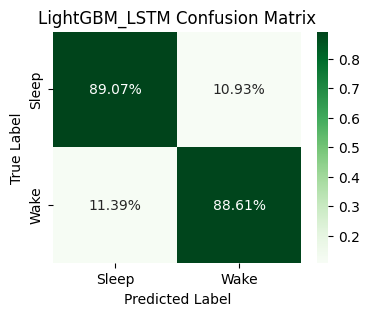

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,LightGBM_LSTM,0.83612,0.886055,0.860363,0.890694,0.943702,0.917287,0.888902,0.764952


In [11]:
dataloader_test = LSTM_dataloader(
    prob_ls_test, len_test, true_ls_test, batch_size=1
)
lgb_lstm_test_results_df = LSTM_eval(LSTM_model, dataloader_test, true_ls_test, 'LightGBM_LSTM')
lgb_lstm_test_results_df

### GPBoosting

In [12]:
final_gpb_model = GPBoost_engine(X_train_resampled, group_train_resampled, y_train_resampled, X_val, y_val, group_val)

100%|██████████| 10/10 [01:56<00:00, 11.62s/trial, best loss: -0.7153744201457919]
Best hyperparameters: {'feature_fraction': 0.699467909379415, 'lambda_l1': 30.0, 'lambda_l2': 5.543584812025214, 'learning_rate': 0.006974833276437917, 'max_depth': 5.0, 'neg_bagging_fraction': 0.7045297987957101, 'num_boost_round': 1000.0, 'num_leaves': 80.0, 'pos_bagging_fraction': 0.8672206608022794}


Found `num_boost_round` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 91238
[GPBoost] [Info] Number of data points in the train set: 66126, number of used features: 358
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=3.808327
[GPBoost] [Info] Start training from score 3.808327
[1]	valid_0's test_neg_log_likelihood: 0.667377
[2]	valid_0's test_neg_log_likelihood: 0.666065
[3]	valid_0's test_neg_log_likelihood: 0.664897
[4]	valid_0's test_neg_log_likelihood: 0.66364
[5]	valid_0's test_neg_log_likelihood: 0.662501
[6]	valid_0's test_neg_log_likelihood: 0.661251
[7]	valid_0's test_neg_log_likelihood: 0.66004
[8]	valid_0's test_neg_log_likelihood: 0.658794
[9]	valid_0's test_neg_log_likelihood: 0.65753
[10]	valid_0's test_neg_log_likelihood: 0.656272
[11]	valid_0's test_neg_log_likelihood: 0.654982
[12]	valid_0's test_neg_log_likelihood: 0.653809
[13]	valid_0's test_neg_log_likelihood: 0.652677
[14]	valid_0's test_neg_log_likelihood: 0.651549
[15]	valid_0's test_neg_log_likelihood: 0.65034
[16]	valid_0's test

[[30296  2767]
 [ 4648 19972]]


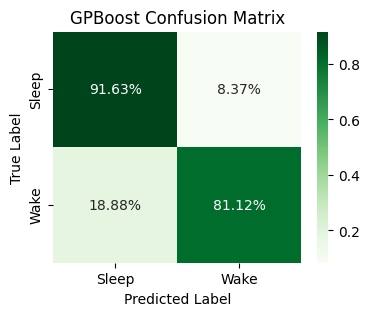

[[9124 1278]
 [1065 5482]]


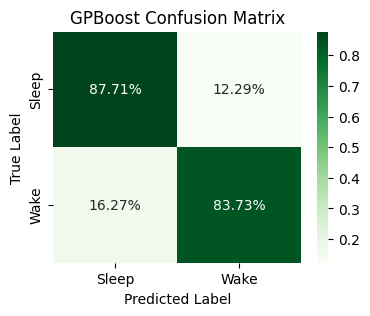

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,GPBoost,0.810947,0.83733,0.823927,0.877139,0.926872,0.907056,0.861762,0.703761


In [13]:
# calculate training scores
prob_ls_train, len_train, true_ls_train = compute_probabilities(
    train_sids, SW_df, final_features, 'gpb', final_gpb_model, group_variable)
gpb_train_results_df = GPBoost_result(final_gpb_model, X_train, y_train, group_train, prob_ls_train, true_ls_train)

# calculate testing scores
prob_ls_test, len_test, true_ls_test = compute_probabilities(
    test_sids, SW_df, final_features, 'gpb', final_gpb_model, group_variable)
gpb_test_results_df = GPBoost_result(final_gpb_model, X_test, y_test, group_test, prob_ls_test, true_ls_test)
gpb_test_results_df

### GPBoost + LSTM post processing

In [14]:
dataloader_train = LSTM_dataloader(
    prob_ls_train, len_train, true_ls_train, batch_size=32
)

# Run LSTM model
LSTM_model = LSTM_engine(dataloader_train, num_epoch=300, hidden_layer_size=32, learning_rate = 0.001) # set your num_epoch

Training on cpu


dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1


Epoch 5/300 - Loss: 0.6746, Accuracy: 0.5133
Epoch 10/300 - Loss: 0.6398, Accuracy: 0.5115
Epoch 15/300 - Loss: 0.5825, Accuracy: 0.6910
Epoch 20/300 - Loss: 0.4448, Accuracy: 0.7720
Epoch 25/300 - Loss: 0.3593, Accuracy: 0.7760
Epoch 30/300 - Loss: 0.3477, Accuracy: 0.7786
Epoch 35/300 - Loss: 0.3328, Accuracy: 0.7870
Epoch 40/300 - Loss: 0.3245, Accuracy: 0.7881
Epoch 45/300 - Loss: 0.3193, Accuracy: 0.7885
Epoch 50/300 - Loss: 0.3154, Accuracy: 0.7893
Epoch 55/300 - Loss: 0.3124, Accuracy: 0.7896
Epoch 60/300 - Loss: 0.3099, Accuracy: 0.7897
Epoch 65/300 - Loss: 0.3076, Accuracy: 0.7899
Epoch 70/300 - Loss: 0.3055, Accuracy: 0.9040
Epoch 75/300 - Loss: 0.3036, Accuracy: 0.9042
Epoch 80/300 - Loss: 0.3019, Accuracy: 0.9042
Epoch 85/300 - Loss: 0.3002, Accuracy: 0.9043
Epoch 90/300 - Loss: 0.2987, Accuracy: 0.9045
Epoch 95/300 - Loss: 0.2972, Accuracy: 0.9046
Epoch 100/300 - Loss: 0.2957, Accuracy: 0.9049
Epoch 105/300 - Loss: 0.2943, Accuracy: 0.9050
Epoch 110/300 - Loss: 0.2929, Acc

[[9290 1112]
 [ 784 5763]]


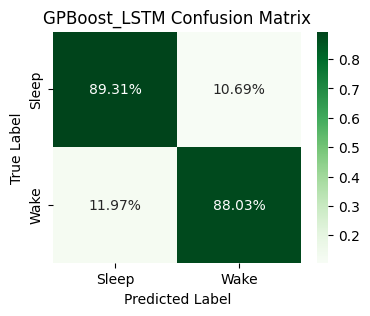

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,GPBoost_LSTM,0.838255,0.88025,0.858739,0.893097,0.942228,0.91401,0.888135,0.763082


In [15]:
dataloader_test = LSTM_dataloader(
    prob_ls_test, len_test, true_ls_test, batch_size=1
)

gpb_lstm_test_results_df = LSTM_eval(LSTM_model, dataloader_test, true_ls_test, 'GPBoost_LSTM')
gpb_lstm_test_results_df

In [16]:
overall_result = pd.concat([lgb_test_results_df, lgb_lstm_test_results_df, 
                            gpb_test_results_df, gpb_lstm_test_results_df])
print(group_variable)
overall_result

['AHI_Severity']


,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,LightGBM,0.781997,0.874446,0.825642,0.846568,0.934920,0.917605,0.857337,0.696148
0,LightGBM_LSTM,0.836120,0.886055,0.860363,0.890694,0.943702,0.917287,0.888902,0.764952
0,GPBoost,0.810947,0.837330,0.823927,0.877139,0.926872,0.907056,0.861762,0.703761
0,GPBoost_LSTM,0.838255,0.880250,0.858739,0.893097,0.942228,0.914010,0.888135,0.763082
